<a href="https://colab.research.google.com/github/dasunkasthury/Face_Recognition_with_tf/blob/main/notebook_script/Face_recognition_with_tf_version1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown --id 1La5FGEDMf8k_AO91UKeqyUcMxu5Dvq98
!mkdir data
!unzip '/content/data.zip' -d '/content/data/'
!rm -r data.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1La5FGEDMf8k_AO91UKeqyUcMxu5Dvq98
From (redirected): https://drive.google.com/uc?id=1La5FGEDMf8k_AO91UKeqyUcMxu5Dvq98&confirm=t&uuid=eb7ba725-a11e-4d02-9050-abacabf3bfd5
To: /content/data.zip
100% 35.7M/35.7M [00:00<00:00, 83.4MB/s]
Archive:  /content/data.zip
   creating: /content/data/aug_data/
   creating: /content/data/aug_data/test/
   creating: /content/data/aug_data/test/images/
   creating: /content/data/aug_data/test/labels/
   creating: /content/data/aug_data/train/
   creating: /content/data/aug_data/train/images/
   creating: /content/data/aug_data/train/labels/
   creating: /content/data/aug_data/val/
   creating: /content/data/aug_data/val/images/
   creating: /content/data/aug_data/val/labels

In [2]:
#train - 281
#test - 60
#val -60

In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import os
import albumentations as alb
import time
import uuid
import cv2

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

array([[[159, 170, 174],
        [159, 170, 174],
        [159, 170, 174],
        ...,
        [198, 193, 190],
        [198, 193, 190],
        [198, 193, 190]],

       [[158, 169, 173],
        [158, 169, 173],
        [158, 169, 173],
        ...,
        [197, 192, 189],
        [197, 192, 189],
        [197, 192, 189]],

       [[158, 167, 172],
        [158, 167, 172],
        [159, 169, 171],
        ...,
        [196, 192, 189],
        [196, 192, 189],
        [196, 192, 189]],

       ...,

       [[158, 177, 219],
        [160, 179, 221],
        [159, 181, 222],
        ...,
        [171, 162, 153],
        [170, 161, 152],
        [170, 161, 152]],

       [[158, 177, 219],
        [160, 179, 221],
        [162, 181, 223],
        ...,
        [171, 162, 153],
        [170, 161, 152],
        [170, 161, 152]],

       [[158, 177, 219],
        [160, 179, 221],
        [162, 181, 223],
        ...,
        [171, 162, 153],
        [171, 162, 153],
        [171, 162, 153]]], dtype=uint8)
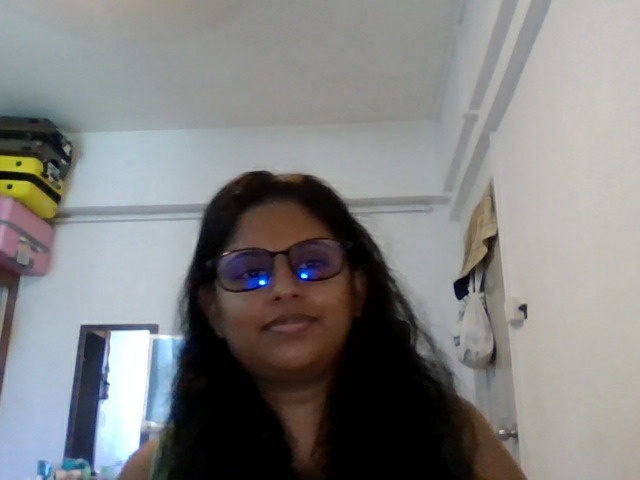

In [4]:
# for testing
images = tf.data.Dataset.list_files('/content/data/train/images/*.jpg', shuffle=False)
images = images.map(load_image)
images.as_numpy_iterator().next()

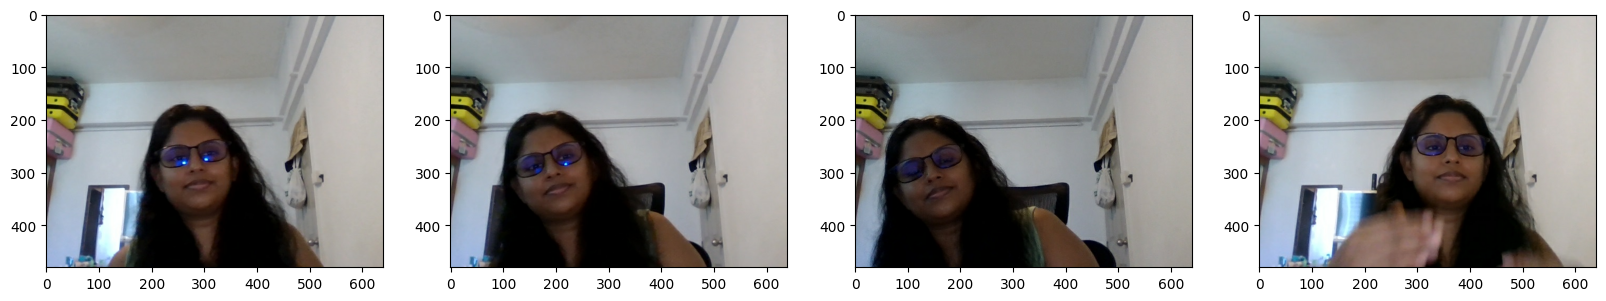

In [7]:
# for testing
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [5]:
# to move lables to corresponding folder by image name

for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('/content/data/', folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('/content/data/','label', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('/content/data/',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

In [6]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                       bbox_params=alb.BboxParams(format='albumentations',
                                                  label_fields=['class_labels']))

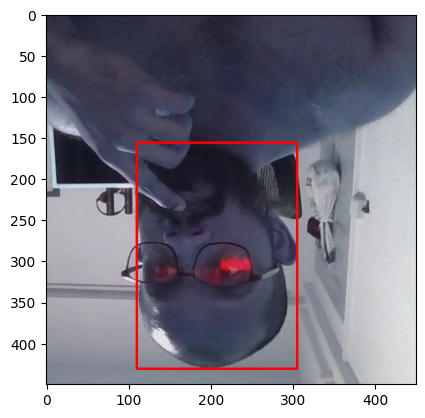

In [10]:
#testing
img = cv2.imread(os.path.join('/content','data','train', 'images','d7ab96e9-9210-11ef-b6ab-141333359ea4.jpg'))
with open(os.path.join('/content', 'data', 'train', 'labels', 'd7ab96e9-9210-11ef-b6ab-141333359ea4.json'), 'r') as f:
    label = json.load(f)

coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

coords = list(np.divide(coords, [640,480,640,480]))
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [7]:
# generate new images with augmentation
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('/content/data/', partition, 'images')):
        img = cv2.imread(os.path.join('/content/data/', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('/content/data/', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('/content/data/aug_data/', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0


                with open(os.path.join('/content/data/aug_data/', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.41049758 0.08737864 0.41049758 0.0894013  0.        ].
x_max is less than or equal to x_min for bbox [0.83373785 0.86913431 0.52654731 0.31796116 0.        ].
x_max is less than or equal to x_min for bbox [0.80491507 0.98139161 0.36498785 0.15918285 0.        ].
x_max is less than or equal to x_min for bbox [0.80036408 0.90250808 0.35057646 0.15614887 0.        ].
x_max is less than or equal to x_min for bbox [0.61908376 0.84890777 0.19660194 0.20368123 0.        ].
x_max is less than or equal to x_min for bbox [0.38698423 0.13389967 0.38698423 0.1197411  0.        ].
x_max is less than or equal to x_min for bbox [0.99605584 0.84890777 0.71389562 0.25627023 0.        ].
x_max is less than or equal to x_min for bbox [0.42945996 0.19660194 0.42870146 0.1986246  0.        ].
x_max is less than or equal to x_min for bbox [0.67824638 0.78114885 0.30961773 0.26537216 0.        ].
x_max is less than or equal to x_min for bbox [0.74954492 0.9419

In [8]:
train_images = tf.data.Dataset.list_files('/content/data/aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [9]:
test_images = tf.data.Dataset.list_files('/content/data/aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [10]:
val_images = tf.data.Dataset.list_files('/content/data/aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [11]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

In [12]:
train_labels = tf.data.Dataset.list_files('/content/data/aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [13]:
test_labels = tf.data.Dataset.list_files('/content/data/aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [14]:
val_labels = tf.data.Dataset.list_files('/content/data/aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [19]:
#test
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(16200, 16200, 3540, 3540, 3420, 3420)

In [15]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(20000)
train = train.batch(8)
train = train.prefetch(4)

In [16]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(5000)
test = test.batch(8)
test = test.prefetch(4)

In [17]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(5000)
val = val.batch(8)
val = val.prefetch(4)

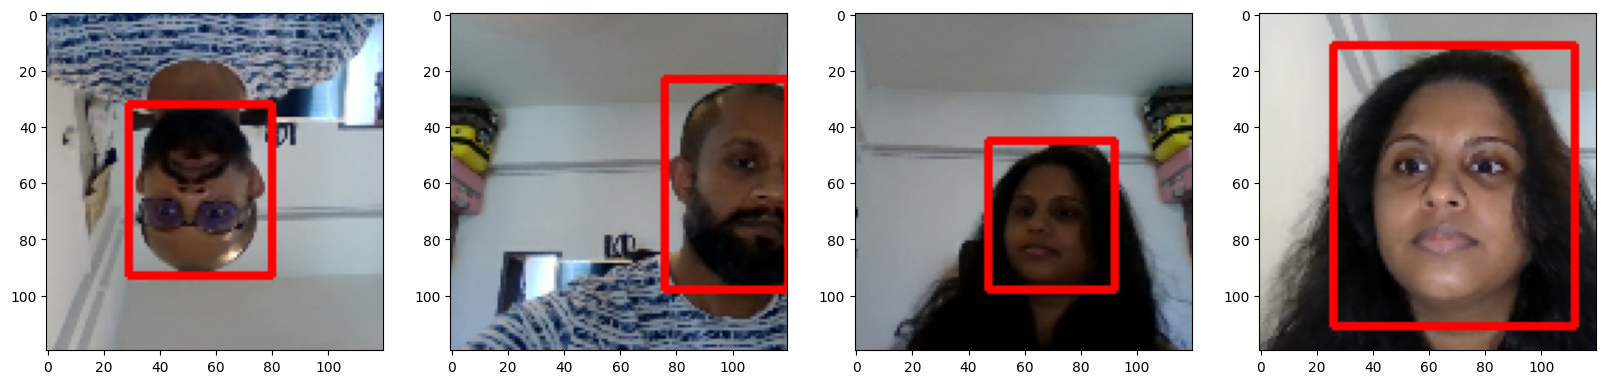

In [23]:
#test
data_samples = train.as_numpy_iterator()
res = data_samples.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
  sample_imagess = res[0][idx].copy()
  sample_coords = res[1][1][idx]

  cv2.rectangle(sample_imagess,
                tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                      (255,0,0), 2)

  ax[idx].imshow(sample_imagess)

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [19]:
vgg = VGG16(include_top=False) # originally it used ssd the move to vgg16

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [21]:
facetracker = build_model()

batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)



/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [22]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [23]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss


In [24]:
class FaceTracker(Model):
    def __init__(self, facetracker,  **kwargs):
        super().__init__(**kwargs)
        self.model = facetracker
        print("This is called --> __init__")

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
        print("This is called --> compile")

    def train_step(self, batch, **kwargs):

        input_layer = Input(shape=(120,120,3))

        X, y = batch
        print("Input shape:", X.shape)
        print("f.shape(X)[0]:", tf.shape(X)[0])
        print("Classes shape:", y[0].shape)
        print("Coordinates shape:", y[1].shape)
        print("train.as_numpy_iterator().next()[0].shape    :", batch)



        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            print("Classes output shape:", classes.shape)
            print("Coordinates output shape:", coords.shape)

            y[0].set_shape([None,1])

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss+(0.5*batch_classloss)

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)
        y[0].set_shape([None,1])

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [25]:
model = FaceTracker(facetracker)
model.compile(opt, classloss, regressloss)
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) # fit is going to trigger def train_step(self, batch, **kwargs):


This is called --> __init__
This is called --> compile


In [32]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 63s 25ms/step - class_loss: 0.0099 - regress_loss: 0.0236 - total_loss: 0.0286 - val_class_loss: 0.7232 - val_regress_loss: 0.7652 - val_total_loss: 1.1268
Epoch 2/40
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 63s 24ms/step - class_loss: 0.0093 - regress_loss: 0.0219 - total_loss: 0.0266 - val_class_loss: 0.0358 - val_regress_loss: 0.1035 - val_total_loss: 0.1214
Epoch 3/40
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 63s 24ms/step - class_loss: 0.0103 - regress_loss: 0.0248 - total_loss: 0.0299 - val_class_loss: 1.9747e-06 - val_regress_loss: 0.0052 - val_total_loss: 0.0052
Epoch 4/40
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 63s 25ms/step - class_loss: 0.0120 - regress_loss: 0.0286 - total_loss: 0.0346 - val_class_loss: 4.9438e-07 - val_regress_loss: 0.0067 - val_total_loss: 0.0067
Epoch 5/40
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 63s 24ms/step - class_loss: 0.0071 - regress_loss: 0.0164 - total_loss: 0.0200 - val_class_loss: 1.4011e-06 - val_regress_loss: 0.0358 - val_total_loss: 0.035

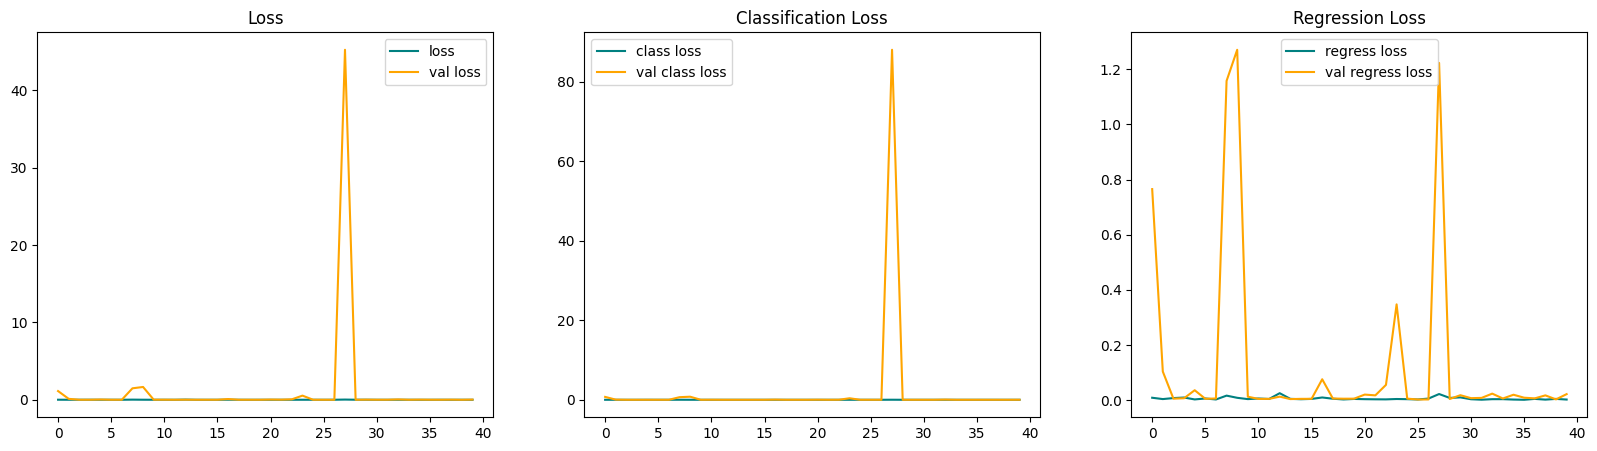

In [33]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [34]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()

In [35]:
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


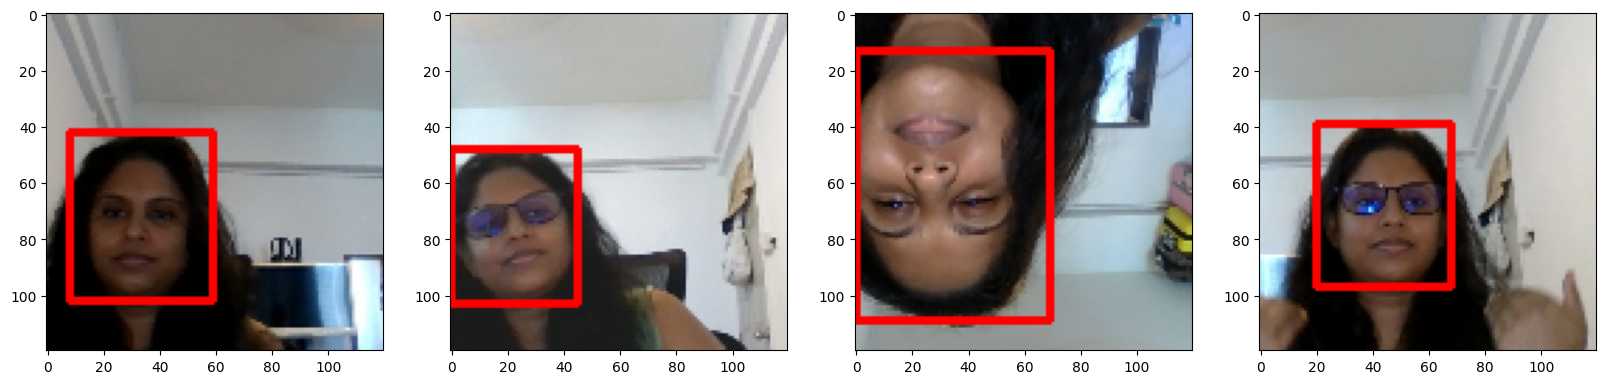

In [36]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx].copy()
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                            (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [37]:
facetracker.save('facetracker_largedata_40h.h5')